<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/eda/6.0_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Salary and Education in Wisconsin - 6.0 Salary Prediction


### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')

### Functions

In [0]:
# To help with the pie charts later
def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

## Analysis


### Salary Linear Regression V1

In [0]:
regression_v1_select = '''
SELECT
  research_id,
  gender,
  race_ethnicity_cd,
  birth_year,
  contract_high_degree_cd,
  contract_days,
  contract_local_experience,
  contract_total_experience,
  cesa_num,
  assignment_fte,
  assignment_requires_dpi_license,
  assignment_staff_category_cd,
  position_classification,
  assignment_position_cd,
  assignment_area_cd,
  assignment_work_school_level_cd,
  salary
FROM
  {}.{}
WHERE
  assignment_fte = 1 and salary is not null
'''.format(refined_dataset_name, '2017_all_staff_report')

In [25]:
df_v1_regression = pd.read_gbq(regression_v1_select, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [9]:
df_v1_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55633 entries, 0 to 55632
Data columns (total 17 columns):
research_id                        55633 non-null int64
gender                             55633 non-null object
race_ethnicity_cd                  55633 non-null object
birth_year                         55633 non-null int64
contract_high_degree_cd            55628 non-null object
contract_days                      55633 non-null int64
contract_local_experience          55633 non-null float64
contract_total_experience          55633 non-null float64
cesa_num                           55572 non-null object
assignment_fte                     55633 non-null float64
assignment_requires_dpi_license    55633 non-null object
assignment_staff_category_cd       55633 non-null object
position_classification            55633 non-null object
assignment_position_cd             55633 non-null object
assignment_area_cd                 55633 non-null object
assignment_work_school_level_cd    5

### One-hot encoding...

In [0]:
df_working = df_v1_regression

In [0]:
df_working = pd.concat([df_working.drop('gender', axis=1), pd.get_dummies(df_working['gender'],prefix='gender')], axis=1)
df_working = pd.concat([df_working.drop('race_ethnicity_cd', axis=1), pd.get_dummies(df_working['race_ethnicity_cd'],prefix='ethnicity')], axis=1)
df_working = pd.concat([df_working.drop('contract_high_degree_cd', axis=1), pd.get_dummies(df_working['contract_high_degree_cd'],prefix='degree')], axis=1)
df_working = pd.concat([df_working.drop('cesa_num', axis=1), pd.get_dummies(df_working['cesa_num'],prefix='cesa')], axis=1)
df_working = pd.concat([df_working.drop('assignment_staff_category_cd', axis=1), pd.get_dummies(df_working['assignment_staff_category_cd'],prefix='assignment_staff_category_cd')], axis=1)
df_working = pd.concat([df_working.drop('position_classification', axis=1), pd.get_dummies(df_working['position_classification'])], axis=1)
df_working = pd.concat([df_working.drop('assignment_work_school_level_cd', axis=1), pd.get_dummies(df_working['assignment_work_school_level_cd'],prefix='assignment_work_school_level_cd')], axis=1)

In [0]:
df_working = df_working.drop(['assignment_requires_dpi_license','assignment_position_cd','assignment_area_cd'], axis=1)

In [0]:
df_working.columns = df_working.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [0]:
target = df_working['salary']
data = df_working.drop('salary', axis=1)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

In [65]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
model.score(X_test, y_test)

0.8006574018212655

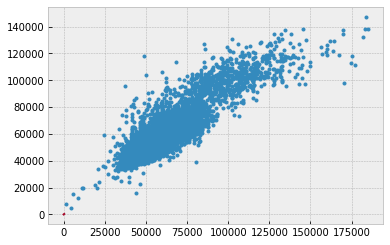

In [68]:
y_pred = model.predict(X_test)
plt.plot(y_test, y_pred, '.')

x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()